# Drift detection and characterization

** -- This tutorial is still under development. It should currently be working and largely correct, but it likely still contains some mistakes. -- **

This tutorial shows how to implement drift detection, and a limited characterization, on time-stamped data. This data can be from almost any quantum-circuit based experiment on one or more qubits, as long as the data is taken using a suitable time-ordering of the experiments, and the data is recorded as a time series. For example, possible experiments include suitably time-ordered GST, RPE, Ramsey or RB experiments.

Later in this notebook we will detail the permisable formats of the time-stamped data, introduce the analysis techniques, provide detailed examples of implementing the analysis, and suggest possible experiments on which to implement the analysis. However, we will begin with a simple demonstration of the method.

In [1]:
from __future__ import print_function

# Importing the drift module is essential
from pygsti.extras import drift

# Importing all of pyGSTi is optional, but often useful.
import pygsti

## A quick overview
We now give a quick overview of the drift detection and characterization methods in the `drift` module, and what kind of output they provide. Full details are given later in this tutorial. As we demonstrate below, the analysis can be implemented with only two steps:

1. Import some timestamped data, into a `pyGSTi` dataset.
2. Pass this data to a single analysis function, `drift.do_basic_drift_characterization()`.

Here we demonstrate this with time series GST data, on the $G_i$, $G_x$, $G_y$ gateset, generated from a simulation (the code required to run these simulations is not currently available in `pyGSTi`). In this simulation the $G_i$ gate has low-frequency drift, the $G_x$ has high-frequency drift, and the $G_y$ gate is drift-free (where "low" and "high" frequency are with respect to the sample rate). More details on the input data format are given later.

In [2]:
ds = pygsti.io.load_tddataset("tutorial_files/timeseries_data.txt")

Loading tutorial_files/timeseries_data.txt: 100%


In [3]:
# This takes 5 - 10 minutes, but can be sped up a lot with more user input (see later).
results_gst = drift.do_basic_drift_characterization(ds)

Thats it! Everything has been calculated, and we can now look at the results. One useful result is printed below: a yes/no outcome for whether or not drift is detected. This is calculated using multiple statistical tests on the data at a specified global confidence level (which defaults to 0.95). That is, there is a probability of at most 0.05 that this function will report drift when there is none. Further details on how to interpret this are given later.

In [4]:
results_gst.any_drift_detect()

Statistical tests set at a global confidence level of: 0.95
Result: The 'no drift' hypothesis *is* rejected.


We can plot power spectra, which *should* be flat - up to statistical flucations, due to finite-sampling noise, around the mean noise level - if there is no drift. There are a range of power spectra that we can plot, but the most useful for an overview of the data is the "global power spectrum", obtained from averaging power spectra calculated from the individual data for each of the different gate sequences (again, details on exactly what this is are given later). This is plotted below. If there are peaks above the significance threshold, this power spectra provides statistically significant evidence of drift.

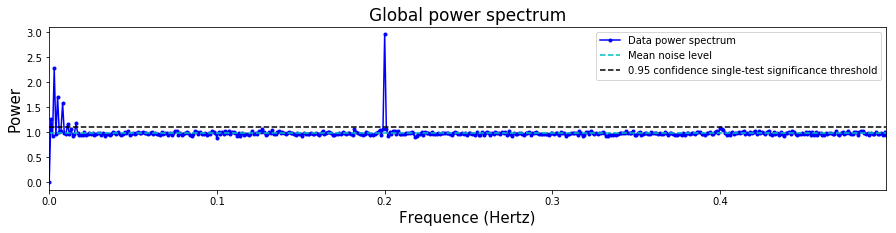

In [5]:
results_gst.plot_power_spectrum()

If we have detected drift, we would probably likely like to know the frequencies of the drift. This information can be extracted from the results object as shown below. All frequencies will be in Hz, when the timestamps have been provided in seconds (again, details later). Note that these are the frequencies in the drifting outcome probabilities; they are *not* directly the frequencies of drift in, say, a Hamiltonian parameter. However, they are closely related to those frequencies (again, more on this below).

In [6]:
print(results_gst.global_drift_frequencies)

[ 0.001  0.003  0.005  0.008  0.011  0.016  0.2  ]


There are individual power spectra for all of the sequences. E.g., if we are interested in whether the $G_xG_i^{128}G_y$ sequence shows signs of drift, we can plot the power spectrum:

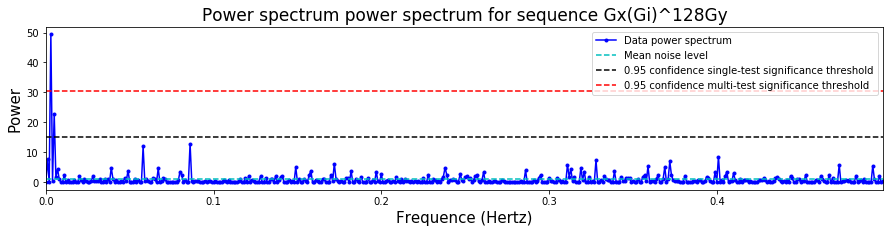

In [7]:
# The gatestring we are interested
gstr = pygsti.objects.GateString(None,'Gx(Gi)^128Gy') 
# We hand the gatestring to the plotting function
results_gst.plot_power_spectrum(sequence=gstr,loc='upper right')

If the data is from GST experiments, or anything with a GST-like structure of germs and fudicials, we can create a box-plot which shows the maximum power in the spectrum for each sequence. This maximum power is a reasonable proxy for comparing how "drifty" the data from the different sequences appears to be. But note that the maximum power should *not* be used to directly compare the level of drift in two different datasets with different parameters, particularly if the number of timestamps is different - because this maximum power will increase with more data, for a fixed level of drift - again, more on this later. 

In the plot below we see that the amount of drift appears to be increasing with sequence length, as would be expected with gate drift. Without performing a detailed analysis, by eye it is clear that the $G_i$ gate is the most drifty, that the $G_x$ gate has some drift, and that the data looks consistent with a drift-free $G_y$ gate.

In [8]:
# This box constructs some GST objects, needed to create any sort of boxplot with GST data
from pygsti.construction import std1Q_XYI # The gateset used with the GST data we imported

# This manually specifies the germ and fiducial structure for the imported data.
fiducial_strs = ['{}','Gx','Gy','GxGx','GxGxGx','GyGyGy']
germ_strs = ['Gi','Gx','Gy','GxGy','GxGyGi','GxGiGy','GxGiGi','GyGiGi','GxGxGiGy','GxGyGyGi','GxGxGyGxGyGy']
log2maxL = 9 # log2 of the maximum germ power

# Below we use the maxlength, germ and fuducial lists to create the GST structures needed for box plots.
fiducials = [pygsti.objects.GateString(None,fs) for fs in fiducial_strs]
germs = [pygsti.objects.GateString(None,gs) for gs in germ_strs]
max_lengths = [2**i for i in range(0,log2maxL)]
gssList = pygsti.construction.make_lsgst_structs(std1Q_XYI.gates, fiducials, fiducials, germs, max_lengths)  

In [9]:
# Create a workspace to show the boxplot
w = pygsti.report.Workspace()
w.init_notebook_mode(connected=False, autodisplay=True) 

In [10]:
# Create a boxplot of the maximum power in the power spectra for each sequence.
w.ColorBoxPlot('driftpwr', gssList[-1], None, None, driftresults = results_gst)

/Users/tjproct/pyGSTi/packages/pygsti/report/workspaceplots.py:1700: UserWarning:

No dataset specified: using DOF-per-element == 1



The analysis creates estimates of the time-dependent probability, $p(t)$, to obtain a given outcome, for each sequence. Below, we will explain how to access, interpret, and plot all of these estimates. Here, we demonstrate how to plot the estimated $p(t)$ that the analysis concludes is "the most drifty" (the $p(t)$ where the estimated drift has the highest power). Obviously, the more this function oscillates, the more drifty the data for this sequence appears to be.

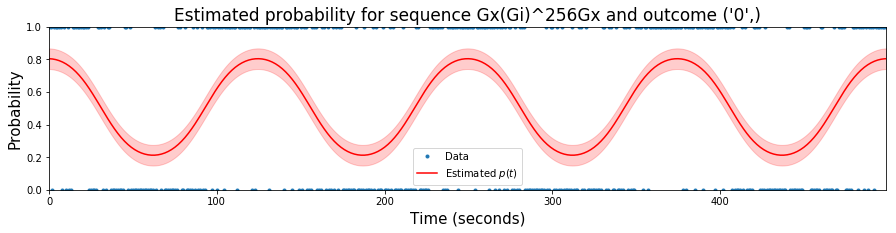

In [11]:
results_gst.plot_most_drifty_probability(plot_data=True)

It can also be informative to display multiple reconstructions on a single plot. Below we plot the reconstructions for the $G_i$ and $G_x$ germs, both with varying germ power and fixed fudicials.

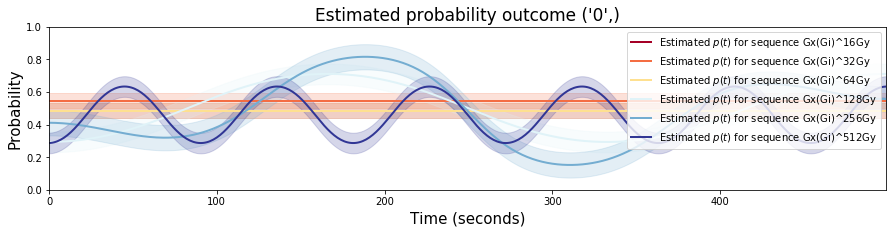

In [12]:
# Pick a list of sequence labels (here gatestrings) or indices to plot the estimated p(t) for
gstrs = [pygsti.objects.GateString(None,'Gx(Gi)^'+str(2**l)+'Gy') for l in range(4,10)]
# Hand this list to the plotting function
results_gst.plot_multi_estimated_probabilities(gstrs,loc='upper right')

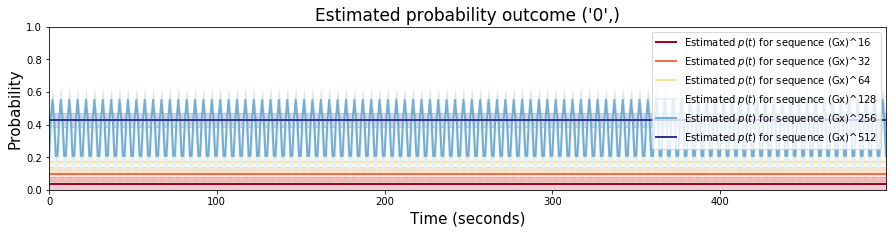

In [13]:
# Pick a list of sequence labels (here gatestrings) or indices to plot the estimated p(t) for
gstrs = [pygsti.objects.GateString(None,'(Gx)^'+str(2**l)) for l in range(4,10)]
# Hand this list to the plotting function
results_gst.plot_multi_estimated_probabilities(gstrs,loc='upper right')

Having provided an overview of the tools in the `drift` module, we now give a more detailed introduction to:
1. The types of data that can be analyzed, and the format they must be imported in to use the `drift` module.
2. The analysis methods that are used inside the `drift.do_basic_drift_characterization()`.
3. How to access the various outputs returned by the analysis, and how to interpret them. 

## Input data types and formats
#### What types of data can be analyzed?

 The methods in this notebook can be used on data from any experiment that satisfies the following criteria: 

- The experiments consist of $S \geq 1$ different circuits, or sequences, each with $M \geq 2$ possible outcomes with $M$ the same for all $S$ circuits.


- Sequence $s$ is repeated, and one of the $M$ outcomes is recorded, $N$ times during each of $T$ different time-intervals, with $N$ and $T$ the same for all sequences $s$. Let $\tau_{s,1},\tau_{s,2},\dots,\tau_{s,T}$ denote times associated with these time-intervals (e.g., the start time or mid-point of each interval).


- The time-gap between consecutive sets of $N$ repeats of a sequence is approximately constant, and approximately independent of sequence. That is $t_{s,gap} \approx \tau_{s,t+1} - \tau_{s,t}$ for all $s,t$ and some constant $t_{s,gap}$ (the time gap is constant for each sequence), and $t_{gap} \equiv t_{s,gap} \approx t_{s',gap}$ for all $s,s'$ (the time gap is the same for every sequence).

#### What type of circuits can the data come from?

Many characterization routines, including GST, RPE, restricted sets of GST sequences (e.g., Ramsey sequences) or RB, satisfy the above criteria *if* a suitable time-ordering for the repeats of all of the sequences is chosen.

An example is a full set of GST sequences, with sequence 1 repeated $N=5$ times, then sequence 2 repeated $N=5$ times, etc, with this entire procedure looped through $T = 500$ times. As long as each circuit follows on from the following circuit with a roughly constant time gap, then -- even if the different circuits take varying times to implement -- the time-gaps between consecutive sets of $N$ repeats of each circuit are all the same.

To obtain best performance, it is preferable to minimize $N$ and maximize $T$ for the same fixed $N \times T$ (this will provide better detection for high frequency drift).


#### What input formats can be used?

Two data formats are allowed:

1. Data can be provided to the analysis function in a `pyGSTi` dataset, which can be imported using the `pygsti.io.load_tddataset()` function, demostrated above. The automated input for this currently has limited functionality, and the analysis is much slower when using this form of input. However, this method has the advantage of simplicity: minimal user specification is required when the analysis uses such a dataset.

2. Data can be provided to the analysis function as an ordinary numpy array. The analysis is faster when using this format. The array can have a range of different dimensions, but the most flexible format is when the array is 4 dimensional. 

Here we will explain the format when the array is 4 dimensional, below we will demonstrate the method with lower dimensional arrays. When the input array is 4 dimensional, the input data format is a numpy array $A$ of dimension $(S \times E \times M_{\rm marg} \times T)$, where
1. $S$ is the number of sequences,
2. $E$ is the number of "entities" (often 1, and more on this below),
3. $M$ is the number of possible measurement outcomes for each circuit,
4. $T$ is the number of timesteps.

The matrix element $A[s,e,m,t]$ should record the number of counts (and value in $0,1,\dots,N-1$) for measurement outcome $m$, on entity $e$, for sequence $s$, with the $t^{\rm th}$ set of repeats for that sequence.

The aspect of this array that is perhaps least inuitive is the "entities" concept. This allows the storing of independent data for different the same circuits, timestamps, and possible measurement outcomes for more than one entity. For example, if multiple single-qubit experiments are implemented in parallel, and any correlations between measurement outcomes are discarded, the data from each qubit can be stored with different entity indexes. This then allows for two things:

1. The analysis function independenty looks for drift in each entity.
2. The analysis function combines the data from all entities, to see if that has evidence for drift which was not evident in the analysis of each entity independently. For example, weak evidence for drift in each entity can combine to convincing evidence for drift in the device as a whole.

Later we will discuss further how to use this "entities" concept to optimize data analysis, via examples.

As shown below, the input data is stored in the results object as an $(S \times E \times M_{\rm marg} \times T)$ array, 
which is the same format as can be used for the input. In our GST example there are 3121 sequences ($S = 3121$), a single entity ($E = 1$), two-outcome measurements ($M=2)$, and 500 timesteps ($T=500$).

In [14]:
import numpy as np
np.shape(results_gst.data)

(3121, 1, 2, 500)

## The analysis methods

#### What is the aim of the methods in this tutorial?

The analysis presented in this tutorial has two purposes: to detect and characterize drift. To explain this further, we need to define what we mean by drift.

There is an underlying probability for circuit $s$ to output the measurement outcome $m$ at time $t$. Denote this by $p_{s,m,t}$, and assume these probabilities satisfy $\sum_m p_{s,m,t} = 1$ for all $s$ and $t$ (i.e., one of the $M$ measurement outcomes is always observed). By definition, there is no drift if $p_{s,m,t} = p_{s,m,t'}$ for all $s,m,t,t'$. Otherwise there is drift. 

In the experiments considered herein, $N$ samples are taken from a multinomial probability distribution with probability vector $(p_{s,0,t},p_{s,1,t},\dots)$ for each $s$ and $m$, at a set of equally-spaced times. As such, the data allows us to estimate properties of the vectors:

$$ \boldsymbol{p}_{s,m} = (p_{s,m,t_1},p_{s,m,t_2},\dots,p_{s,m,t_3}).$$

The aim of our analysis is:

1. **Drift Detection:** Starting from the assumption that there is no drift, decide whether there is statistically significant evidence in the data that $p_{s,m,t}$ is *not* independent of $t$.
2. **Drift characterization:** Estimate $p_{s,m,t}$ for all sample times $t$.

The drift detection and characterization works via spectral analysis, by implement a type of discrete Fourier transform on the data and looking for peaks in the power spectrum that are larger than would be expected if there was no drift.

Specifically, consider a data vector $\boldsymbol{x}=(x_0,x_1,\dots,x_{T-1})$, of the number of counts observed for measurement outcome $m$ with sequence $s$ as a function of time $t \in [0,1,\dots,T]$. We remove the data mean from this vector, and renormalize it in a particular way, to obtain the $\boldsymbol{z}$ vector, defined by:

$$
z_{s,m,t} = \frac{x_{s,m,t} - \bar{x}_{s,m}}{\sqrt{ N\bar{x}_{s,m}(1- \bar{x}_{s,m})}},
$$

We won't fully explain the reasons for this mapping on $\boldsymbol{x}$ here, except to note that (1) it is not essential, and (2) the motivation is that -- after this mapping -- the statisical behaviour of the random variable from which $\boldsymbol{z}$ is drawn, when there is no drift, is largely independent of $N$ and the value of the time-independent probabilitiy $p_{s,m}$.

We then perform a Fourier transform on the data -- specifically, we implement a Type-II orthogonal discrete cosine transform (DCT) -- to obtain Fourier modes $ \tilde{\boldsymbol{z}}_{s,m} = F \boldsymbol{z}_{s,m}$. The precise definition of this transform is not important for obtaining an intuitive understanding of this method, but for completeness it is defined by:

\begin{align}
F_{\omega,t} =\sqrt{\frac{2^{1-\delta_{\omega,0}}}{N}} \cos\left(\frac{\omega \pi}{N}\left( t + \frac{1}{2}\right)\right), 
\end{align}
with $\omega,t=0,\dots,N-1$.

We then square these Fourier modes, to obtain a power spectrum $\tilde{\boldsymbol{z}}_{s,m}^2$ for each measurement outcome and each sequence. It is these power spectra that we analyze to detect and characterize drift. We can look at the individual power spectra for a particular sequence and measurement outcome. Using the central limit theorem and some statistics (which we will not cover here), it can be show that -  when there is no drift - each Fourier mode is approximately a zero-mean unit-variance $\chi^2_1$ random variable. As such, we can calculate the probability that a spike in a power spectrum is due to random statistical flucations, and if this probability is low enough then we can be confident the peak is due to drift. I.e., the underlying $p(t)$ is not constant.

We can also average these power spectra over measurement outcomes, and/or over sequences (and over entities, which haven't been discused above, and on which this entire analysis is independently performed). When averaging over all of these quantities, we obtain the global power spectrum presented above. The advantage of this averaging is that it supresses noise from random flucations, but does not supress any "signal" due to nonconstant $p(t)$ - as long as the same frequencies are present in many of the power spectra that are being averaged.

Before explaining any more of the analysis methods, we turn to a simple example.

## Example 1 : Single sequence data
We demonstrate this on single-sequence data, for a single entity, with two-outcome measurements. This is the circumstance under which the analysis function can be given data in a 1D array, and so we will use this method below. We now demonstrate the method with simulated data for a drifting and drift free probability.

Below we use a drifting probability of
$$ p(t) = 0.5 + 0.2 \cos(0.1 t).,$$
with integer $t$ in the range $0,1,2,\dots,T$.
This is similar in form to the drifting probability that would be obtained with certain sorts of Ramsey experiment with drifting $\sigma_z$ over-rotation angle.

In [22]:
# Imports for generating fake data to demonstrate the methods.
from numpy.random import binomial
from numpy.random import multinomial

In [28]:
N = 5 # Counts per timestep
T = 100 # Number of timesteps

# The confidence of the statistical tests. Here we set it to 0.999, which means that
# if we detect drift we are 0.999 confident that we haven't incorrectly rejected the
# initial hypothesis of no drift.
confidence = 0.999

# A drifting probability to obtain the measurement outcome with index 1 (out of [0,1])
def pt_drift(t): return 0.5+0.2*np.cos(0.1*t)

# A drift-free probability to obtain the measurement outcome with index 1 (out of [0,1])
def pt_nodrift(t): return 0.5

# If we want the sequence to have a label, we define a list for this (here, a list of length 1).
# The labels can, but need not be, pyGSTi GateString objects.
sequences = [pygsti.objects.GateString(None,'Gx(Gi)^64Gx'),]

# If we want the outcomes to have labels, we define a list for this.
outcomes = ['0','1']

# Let's create some fake data by sampling from these p(t) at integer times. Here we have
# created a 1D array, but we could have instead created a 1 x 1 x 1 x T array.
data_1seq_drift = np.array([binomial(N,pt_drift(t)) for t in range(0,T)])
data_1seq_nodrift = np.array([binomial(N,pt_nodrift(t)) for t in range(0,T)])

# If we want frequencies in Hertz, we need to specify the timestep in seconds. If this isn't
# specified, the frequencies are given in 1/timestep with timestep defaulting to 1.
timestep = 1e-5

# We hand these 1D arrays to the analysis function, along with the number of counts, and other
# optional information
results_1seq_drift = drift.do_basic_drift_characterization(data_1seq_drift, counts=N, outcomes=outcomes,
                                                           confidence=confidence, timestep=timestep, 
                                                           indices_to_sequences=sequences)
results_1seq_nodrift = drift.do_basic_drift_characterization(data_1seq_nodrift, counts=N, outcomes=outcomes, 
                                                             confidence=confidence, timestep=timestep, 
                                                             indices_to_sequences=sequences)                                                    

Due to input array format, analysis is defaulting to assuming:
  - single-sequence data
  - single entity data
  - two-outcome measurements

Due to input array format, analysis is defaulting to assuming:
  - single-sequence data
  - single entity data
  - two-outcome measurements



We can now compare the global power spectrum obtained when there is drift, and when there is not drift. Except in highly unusual cases (1 in 1000) there will be no drift detected when there is indeed no drift. 

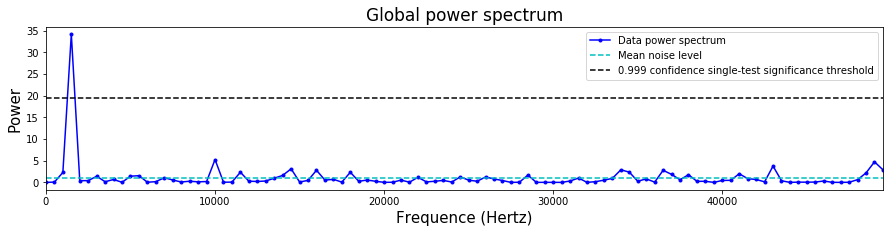

In [29]:
results_1seq_drift.plot_power_spectrum()

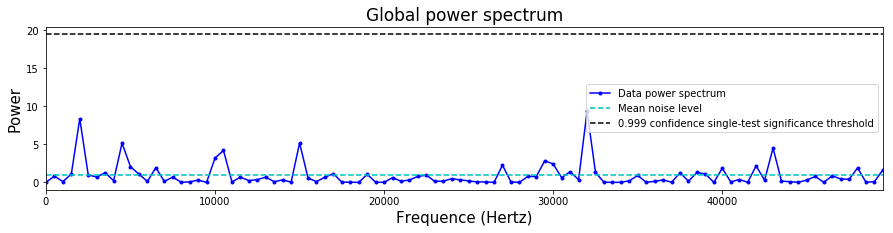

In [30]:
results_1seq_nodrift.plot_power_spectrum()

We can look to see what the p-value associated with the largest peak in the power spectrum is. 

In [31]:
print(results_1seq_drift.global_pvalue)
print(results_1seq_nodrift.global_pvalue)

5.05176252164e-07
0.198571616311


The analysis function performs:
1. an analysis on a per-sequence, per-entity, per-outcome basis (properties starting with `pspepo`), an analysis on a per-sequence, per-entity, outcome-averaged basis (properties starting with `pspe`), 
2. an analysis on a per-sequence, entity-averaged, outcome-averaged basis (properties starting with `ps`), 
3. an analysis on a sequence-averaged, per-entity, outcome-averaged basis (properties starting with `pe`),
4. a global analysis on a sequence-averaged, entity-averaged, outcome-averaged basis (properties starting with `global`)

That is, it inspects all the power spectra, after the relevant averaging has been performed, for evidence of drift (e.g., for case 1 there are $S \times E \times M \times T$ spectra).

In the example here there is a single sequence, a single entity, and two-outcome measurements. Hence, in this case all of the analyzes are exactly equivalent, as is clear by noting that all of the power spectra are the same:

In [32]:
# The power spectrum obtained after averaging over everthing
print(results_1seq_drift.global_power_spectrum[:4])
# The power spectrum obtained after averaging over everthing except sequence label
print(results_1seq_drift.ps_power_spectrum[0,:4])
# The power spectrum obtained after averaging over everthing except entity label
print(results_1seq_drift.pe_power_spectrum[0,:4])
# The power spectrum obtained after averaging over everthing except sequene and entity label
print(results_1seq_drift.pspe_power_spectrum[0,0,:4])
# The two power spectra obtained after averaging over nothing
print(results_1seq_drift.pspepo_power_spectrum[0,0,0,:4])
print(results_1seq_drift.pspepo_power_spectrum[0,0,1,:4])

[  3.15544362e-30   6.64556768e-02   2.28218301e+00   3.41693793e+01]
[  3.15544362e-30   6.64556768e-02   2.28218301e+00   3.41693793e+01]
[  3.15544362e-30   6.64556768e-02   2.28218301e+00   3.41693793e+01]
[  3.15544362e-30   6.64556768e-02   2.28218301e+00   3.41693793e+01]
[  3.15544362e-30   6.64556768e-02   2.28218301e+00   3.41693793e+01]
[  3.15544362e-30   6.64556768e-02   2.28218301e+00   3.41693793e+01]


As we can see above, the power spectra for the two different measurement outcomes are identical. This is because the Fourier modes for all of the measurement outcomes must sum to zero. Hence, there are only $M-1$ independent power spectra, which here is 1.

As already demonstrated above, the analysis function also creates an estimate for the drift probability for each measurement outcome (and for each sequence, and each entity, but here there is only one of each of these). This estimate is created in the following way:

1. Inspect the relevant power spectrum (the power spectrum for the sequence, entity, and measurement outcome under consideration).
2. Take the modes obtained from the data, and set all modes with power below the "significance threshold" to zero. This significance threshold is generally adjusted for the number of sequences and entities considered, which is not relevant in this case but is discussed below.
3. Keep all modes with power above the significance threshold and invert the Fourier transform.
4. This is the estimate of $p(t)$, up to some final adjustments to guarantee that $p(t)$ is within $[0,1]$.

Because we have created our data from a known underlying $p(t)$ we can compare our estimate of $p(t)$ with the true $p(t)$. We do this below.

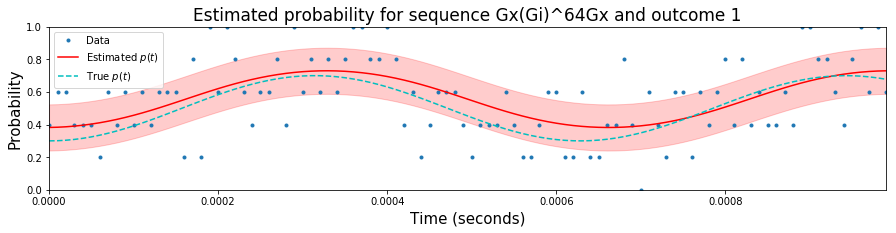

In [34]:
# Lets create an array of the true probability. This needs to be
# of dimension S x E x M x T
parray_1seq = np.zeros((1,1,2,T),float)
parray_1seq[0,0,0,:] = np.array([pt_drift(t) for t in range(0,T)])
parray_1seq[0,0,1,:] = 1 - parray_1seq[0,0,0,:]

# The measurement outcome index we want to look at (here the esimated p(t) 
# for one index is just 1 - the p(t) for the other index, because we are
# looking at a two-outcome measurement).
outcome = 1

# If we hand the parray to the plotting function, it will also plot
# the true probability alongside our estimate from the data
results_1seq_drift.plot_estimated_probability(sequence=0,outcome=outcome,parray=parray_1seq,plot_data=True)

## Example 2 : Single-sequence multi-qubit data
Single sequence data with two measurement outcomes is (a) often not will be obtained in experiments, and (b) is not sufficient to demonstrate all of the methods contained within the analysis function, or to understand all of the ouput. Hence, we now consider an example with a single-sequence and 4 measurement outcomes, which could represent a two-qubit single-sequence experiment.

Let us consider the case of 4 possible measurement outcomes:

In [35]:
# We only explicitly name them for labelling purposes.
outcomes = ['00','01','10','11']

This could correspond to computational basis measurements of two qubits. Now let us assume that the drifting $p(t)$ for obtaining each measurement outcome factorizes into probabilities for outcomes 0 and 1 for each qubit (e.g., because it is parallel single-qubit experiments and there is no crosstalk). Specifically, take the first qubit to have drifting probability for outcome 0 of
$$ p_{0}(t) = 0.5+0.05 \cos(0.08t),$$
and the second qubit to have drifting probability for outcome 0 of
$$ p_{0}(t) = 0.5+0.05 \cos(0.2t),$$
with $t \in [0,1,\dots, T]$.

Let's create some data from these drifting probabilities

In [36]:
N = 10 # Counts per timestep
T = 1000 # Number of timesteps

# The drifting probabilities for the 4 outcomes
def pt00(t): return (0.5+0.07*np.cos(0.08*t))*(0.5+0.08*np.cos(0.2*t))
def pt01(t): return (0.5+0.07*np.cos(0.08*t))*(0.5-0.08*np.cos(0.2*t))
def pt10(t): return (0.5-0.07*np.cos(0.08*t))*(0.5+0.08*np.cos(0.2*t))
def pt11(t): return (0.5-0.07*np.cos(0.08*t))*(0.5-0.08*np.cos(0.2*t))

# Because of the type of input (>2 measurement outcomes), we must record the
# data in a 4D array (even though some of the dimensions are trivial)
data_multiqubit = np.zeros((1,1,4,T),float)

# Generate data from these p(t)
for t in range(0,T):
    data_multiqubit[0,0,:,t] = multinomial(N,[pt00(t),pt01(t),pt10(t),pt11(t)])

#### Example 2.1 : A simple analysis of the full dataset
The simplest way to analyze this data is just to hand it to the drift characterization method, as before (note that now we don't need to specify the counts number, as the input is a 4D array). We do this below.

In [37]:
results_multiqubit_full = drift.do_basic_drift_characterization(data_multiqubit,outcomes=outcomes,confidence=0.99)

By looking at the global power spectrum, we can clearly see that there is drift.

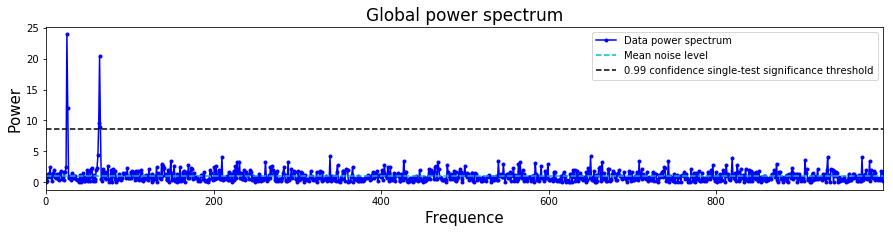

In [38]:
results_multiqubit_full.plot_power_spectrum()

As always, we can also return the frequencies, found from inspecting the global power spectrum. As we have not specified a timestep, these are integers between $1$ and $T-1$.

In [39]:
print(results_multiqubit_full.global_drift_frequencies)

[25 26 63 64 65]


Because there are multiple measurement outcomes, we can look at the power spectra for each of these, and also we can look at the drift frequencies found from just analyzing this spectrum. One example of such a power spectrum is given below

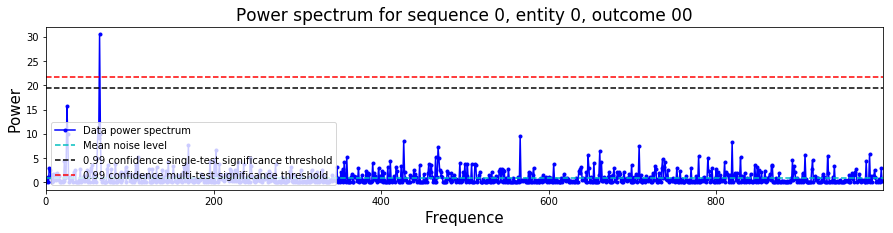

In [40]:
outcome = 0 # the outcome index associated with the '00' outcome
results_multiqubit_full.plot_power_spectrum(sequence=0,entity=0,outcome=outcome)

The drift frequencies found via an independent analysis of each of these spectra. Generally, these need not contain the same frequencies as the global analysis. In this example, because all of the frequencies appear in all of the spectra, the global analysis is more sensitive (reduced noise without reducing signal strength). 

In [41]:
print(results_multiqubit_full.pspepo_drift_frequencies[0,0,0])
print(results_multiqubit_full.pspepo_drift_frequencies[0,0,1])
print(results_multiqubit_full.pspepo_drift_frequencies[0,0,2])
print(results_multiqubit_full.pspepo_drift_frequencies[0,0,3])

[64]
[25]
[25]
[64]


As always, we can also look at the reconstruction for a given drifting probability. An example is shown below, where again we construct the true underlying probability with which to compare it.

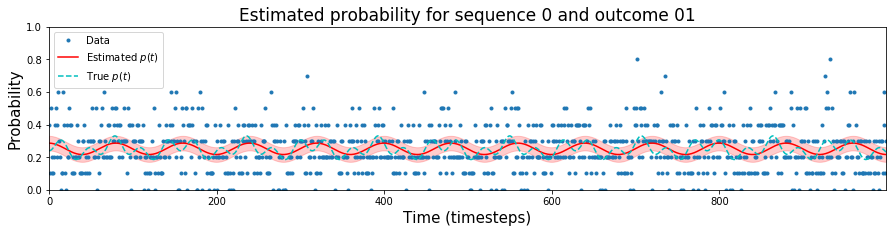

In [42]:
# Creates an array of the true probability.
parray_multiqubit_full = np.zeros((1,1,4,T),float)
parray_multiqubit_full[0,0,0,:] = np.array([pt00(t) for t in range(0,T)])
parray_multiqubit_full[0,0,1,:] = np.array([pt01(t) for t in range(0,T)])
parray_multiqubit_full[0,0,2,:] = np.array([pt10(t) for t in range(0,T)])
parray_multiqubit_full[0,0,3,:] = np.array([pt11(t) for t in range(0,T)])

results_multiqubit_full.plot_estimated_probability(sequence=0,outcome=1, plot_data=True,
                                                   parray=parray_multiqubit_full)

#### Example 2.2 : Marginalizing over qubits

The above analysis looks for drift in the $2^2$ measurements outcomes of a two-qubit circuit. This would be problematic for many qubits, as for $Q$ qubits there is $2^Q$ possible measurement outcomes, and the probability of any one outcome being observed will - for many circuits - converge to zero as $Q$ increases. Then, even for very large $T$, there could be, e.g., at most 2 counts for any one measurement outcome, and the power spectra obtained will be useless.

However, it is likely in many circumstances that any drift will show up in the marginalized probabilities for obtaining 0 or 1 of each qubit. E.g., in the example above this is precisely what is drifting. We can implement an analysis like this by specifying that the analysis function marginalizes.

To do this in an automated way, we specify ` marginalize = 'std'`. This then assumes that the data is such that the 0th indexed outcomes is the bitstring 0...0000, the 1st indexed outcome is the bitstring 0...0001, etc. It then associates the first qubit with entity 0 (where first qubit has its measurement outcome recorded as the first bit in the string), the second qubit with entity 1 and so on.

Note that, when using this method, the input data array grows exponentially in the number of qubits. As such, pre-marginalizing will be preferable for a large number of qubits, in which case the data for different qubits should be stored with different "entity" indices.

Below we demonstrate this method on the same data as analyzed above

In [43]:
results_multiqubit_marg = drift.do_basic_drift_characterization(data_multiqubit, outcomes=outcomes, 
                                                                marginalize = 'std', confidence=0.99)

As we can see from the returned data shape, the data has been split into separate sets for 2 different entities, each have two possible measurement outcomes.

In [44]:
np.shape(results_multiqubit_marg.data)

(1, 2, 2, 1000)

As always, we can plot the global power spectrum (averaged over everything, including entity, i.e., qubit).

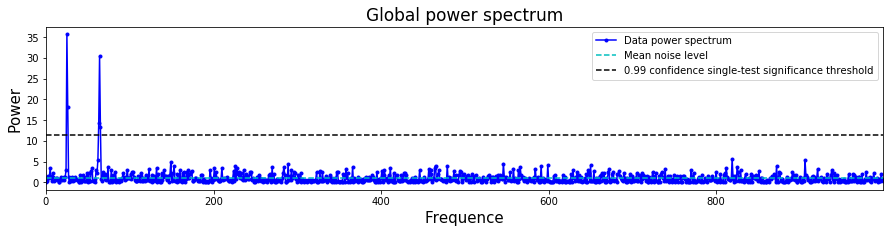

In [45]:
results_multiqubit_marg.plot_power_spectrum()

However, now we can look at the power spectrum for each individual qubit. This then shows us that each qubit has a different drift frequency. Something that was not obvious from the analysis implemented without marginalization. Moreover, these spectra show higher peaks (they are approximately twice as high), because when we construct the global power spectrum we are averaging pure noise with "signal" at both drift frequencies.

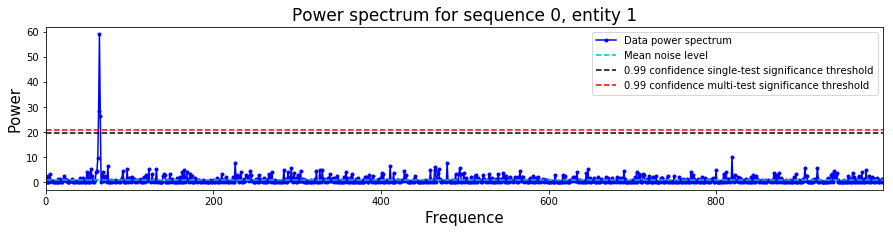

In [46]:
results_multiqubit_marg.plot_power_spectrum(sequence=0,entity=1)

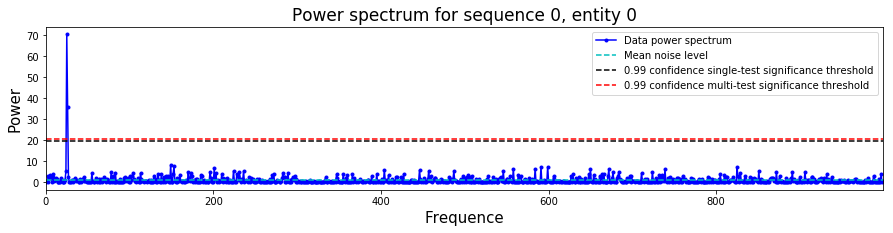

In [47]:
results_multiqubit_marg.plot_power_spectrum(sequence=0,entity=0)

With this analysis we can isolate the drift frequencies of each qubit

In [48]:
# Drift frequencies for the first qubit
print(results_multiqubit_marg.pe_drift_frequencies[0])
# Drift frequencies for the second qubit
print(results_multiqubit_marg.pe_drift_frequencies[1])

[25 26]
[63 64 65]


Finally, we can again plot the estimated drift probabilities. Again, these are more informative that what was obtained without marginalization. In particular, the oscillations are noticably stronger, as they are each the sum of two of the drifting probabilities from the "raw" unmarginalized case.

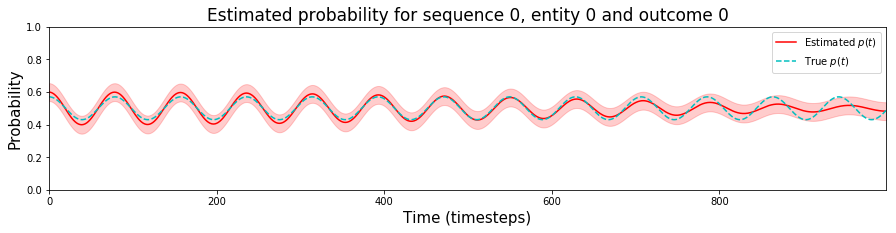

In [49]:
# Creates an array of the true probability.
parray_multiqubit_marg = np.zeros((1,2,2,T),float)
parray_multiqubit_marg[0,0,0,:] = np.array([pt00(t)+pt01(t) for t in range(0,T)])
parray_multiqubit_marg[0,0,1,:] = np.array([pt10(t)+pt11(t) for t in range(0,T)])
parray_multiqubit_marg[0,1,0,:] = np.array([pt00(t)+pt10(t) for t in range(0,T)])
parray_multiqubit_marg[0,1,1,:] = np.array([pt01(t)+pt11(t) for t in range(0,T)])

results_multiqubit_marg.plot_estimated_probability(sequence=0,entity=0,outcome=0,parray=parray_multiqubit_marg)

#### Example 2.3 : Marginalizing over qubits loses information and can miss detectable drift
Marginalizing involves throwing away information about correlations between measurement outcomes. As such, it is insensitive to certain types of drift. In particular, if only the correlations between measurement outcomes are drifting. This is perhaps a rather contrived situation, but it is possible. For example, consider the drifting probabilities:
$$ p_{00}(t) = 0.25-0.05 \cos(0.05*t) $$
$$ p_{01}(t) = 0.25+0.05 \cos(0.05*t) $$
$$ p_{10}(t) = 0.25+0.05 \cos(0.05*t) $$
$$ p_{11}(t) = 0.25-0.05 \cos(0.05*t) $$
In this case, as demonstrated below, the analysis of the full data clearly demonstrates drift, yet the analysis of the marginalized data does not.

In [50]:
N = 10 # Counts per timestep
T = 1000 # Number of timesteps

outcomes = ['00','01','10','11']

def pt_correlated00(t): return 0.25-0.05*np.cos(0.05*t)
def pt_correlated01(t): return 0.25+0.05*np.cos(0.05*t)
def pt_correlated10(t): return 0.25+0.05*np.cos(0.05*t)
def pt_correlated11(t): return 0.25-0.05*np.cos(0.05*t)

data_1seq_multiqubit = np.zeros((1,1,4,T),float)
for t in range(0,T):
    pvec = [pt_correlated00(t),pt_correlated01(t),pt_correlated10(t),pt_correlated11(t)]
    data_1seq_multiqubit[0,0,:,t] = multinomial(N,pvec)
        
results_correlatedrift_marg = drift.do_basic_drift_characterization(data_1seq_multiqubit,
                                                             outcomes=outcomes, marginalize = 'std')

results_correlatedrift_full = drift.do_basic_drift_characterization(data_1seq_multiqubit, 
                                                             outcomes=outcomes, marginalize = 'none')

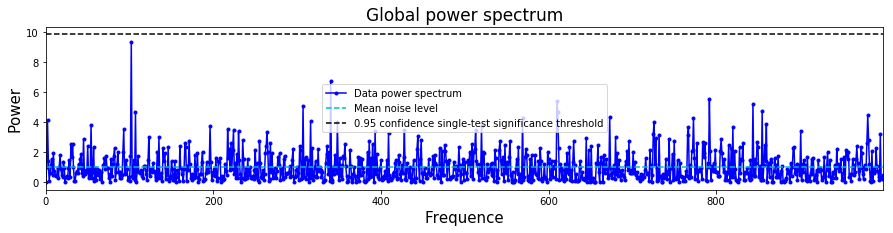

In [51]:
results_correlatedrift_marg.plot_power_spectrum()

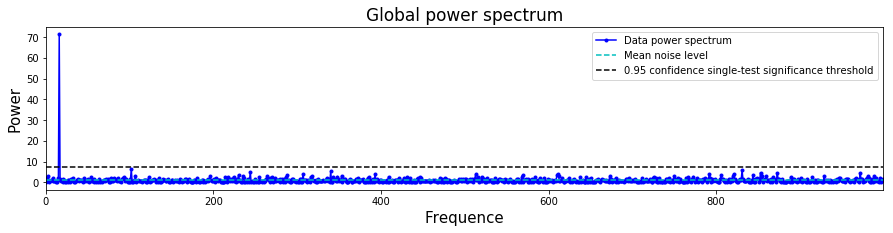

In [52]:
results_correlatedrift_full.plot_power_spectrum()

What this demonstrates is that it is important to carefully decide how to analyze data from a given experiment, with physical motivations for the analysis used.

## Example 3 : Further analysis of the timeseries GST data

** This section is not finished and should not be read **


At a later date, this will be filled in with more details on how to interpret the output of the GST analysis. Things to cover here:
1. How to import bitstring data as an array.
2. Explain how the statistical test thresholds are raised.
3. Put some information on how to interpret p-values when doing multiple tests

In [53]:
data_gst, indices_to_gstrs = drift.load_bitstring_data("tutorial_files/timeseries_data.txt")

In [54]:
fname = "tutorial_files/timeseries_probabilities.txt"
gstrs_to_indices = results_gst.sequences_to_indices
parray_gst = drift.load_bitstring_probabilities(fname,gstrs_to_indices)

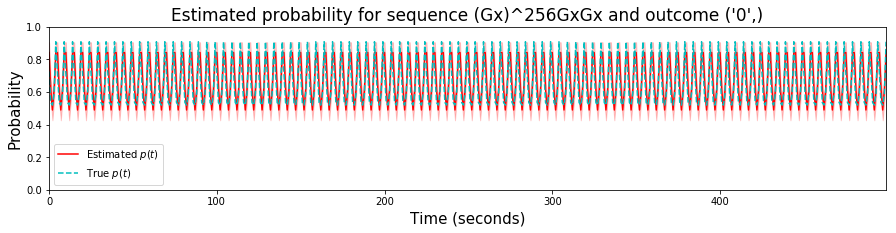

In [55]:
results_gst.plot_estimated_probability(sequence=pygsti.objects.GateString(None,'Gx(Gx)^256Gx'),plot_data=False,parray=parray_gst)